# Miniprojeto 3 - Self Organizing Map

#### Alunos
* Italo Rodrigo Barbosa Paulino - irbp
* José Nilton de Oliveira Lima Júnior - jnolj

O objetivo desse projeto é demonstrar a utilidade dos Mapas de Kohonen, também chamados de Self Organizing Maps (SOM) na visualização de dados e aprendizagem não supervisionada. Para isso, iremos analisar os dados climáticos da provincia de British Columbia, no Canadá. A utilização de SOMs para análise climática é algo que vem ganhando bastante força ultimamente e por isso esta aplicação foi escolhida para exemplicar o uso de SOMs.

Esse relatório seguirá o modelo de código comentado, feito em Python3 e utilizando Jupyter Notebook.

In [1]:
#Importanto bibliotecas relevantes 
import numpy as np
from sompy.sompy import SOMFactory
import pandas as pd
import glob
import os

CACHEDIR=/Users/juniorlima/.matplotlib
Using fontManager instance from /Users/juniorlima/.matplotlib/fontlist-v300.json
Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
# configurando matplotlib para mostrar figuras de forma bonita
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':'tight'}

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10, 10]
%matplotlib inline

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [3]:
# configurando notebook para desabilitar o scroll, facilitando a impressão
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Os dados climáticos estão separados em vários arquivos .csv, por isso é necessário ler os dados e concatená-los em um só pandas dataframe, para facilitar o treinamento.

In [5]:
# lendo os arquivos com os dados 
path = "data/"
all_files = glob.glob(os.path.join(path, "*.csv"))

# juntando os dados em um só dataframe
df_from_each_file = (pd.read_csv(f, skiprows = 31) for f in all_files)
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)

# Somente as colunas Lat, Long, Mean Temp, Max Temp, Min temp, Precipitation são utilizadas, para facilitar a análise
data = concatenated_df[['Lat', 'Long', 'Tm', 'Tx', 'Tn', 'P']]
data = data.apply(pd.to_numeric,  errors='coerce')
data = data.dropna(how='any')
names = ['Latitude', "longitude", 'Monthly Median temperature (C)','Monthly Max temperature (C)', 'Monthly Min temperature (C)', 'Monthly total precipitation (mm)']

print(data.head())

O SOM é criado e treinado. Os neurônios são inicializados utilizando Principal Component Analisys (PCA),
que ajudam na convergencia mais rápida da rede. Porém, não há problema em utilizar valores aleatórios pequenos.

In [8]:

sm = SOMFactory().build(data.values, normalization = 'var', initialization='pca', component_names=names)
sm.train(n_job=1, verbose=False, train_rough_len=2, train_finetune_len=5)

maxtrainlen %d inf
maxtrainlen %d inf


Para analisar o SOM criado, utilizaremos as seguintes medidas. 

*Erro de quantização*: Distancia média entre cada entrada e sua Best Matching Unit (BMU)

*Erro topográfico*: A propoção de, para quantas entradas, a primeira e segunda BMU's não são adjacentes

In [9]:
topographic_error = sm.calculate_topographic_error()
quantization_error = np.mean(sm._bmu[1])
print ("Topographic error = %s; Quantization error = %s" % (topographic_error, quantization_error))

Topographic error = 0.08204911417701087; Quantization error = 0.5591334189558946


Iremos agora começar a utilizar o SOMs para visualizar os dados. Inicialmente, tentar descobrir correlações entre as variávels. Para isso, vamos descobrir quais neuronios representa cada intervalo das features de entrada.


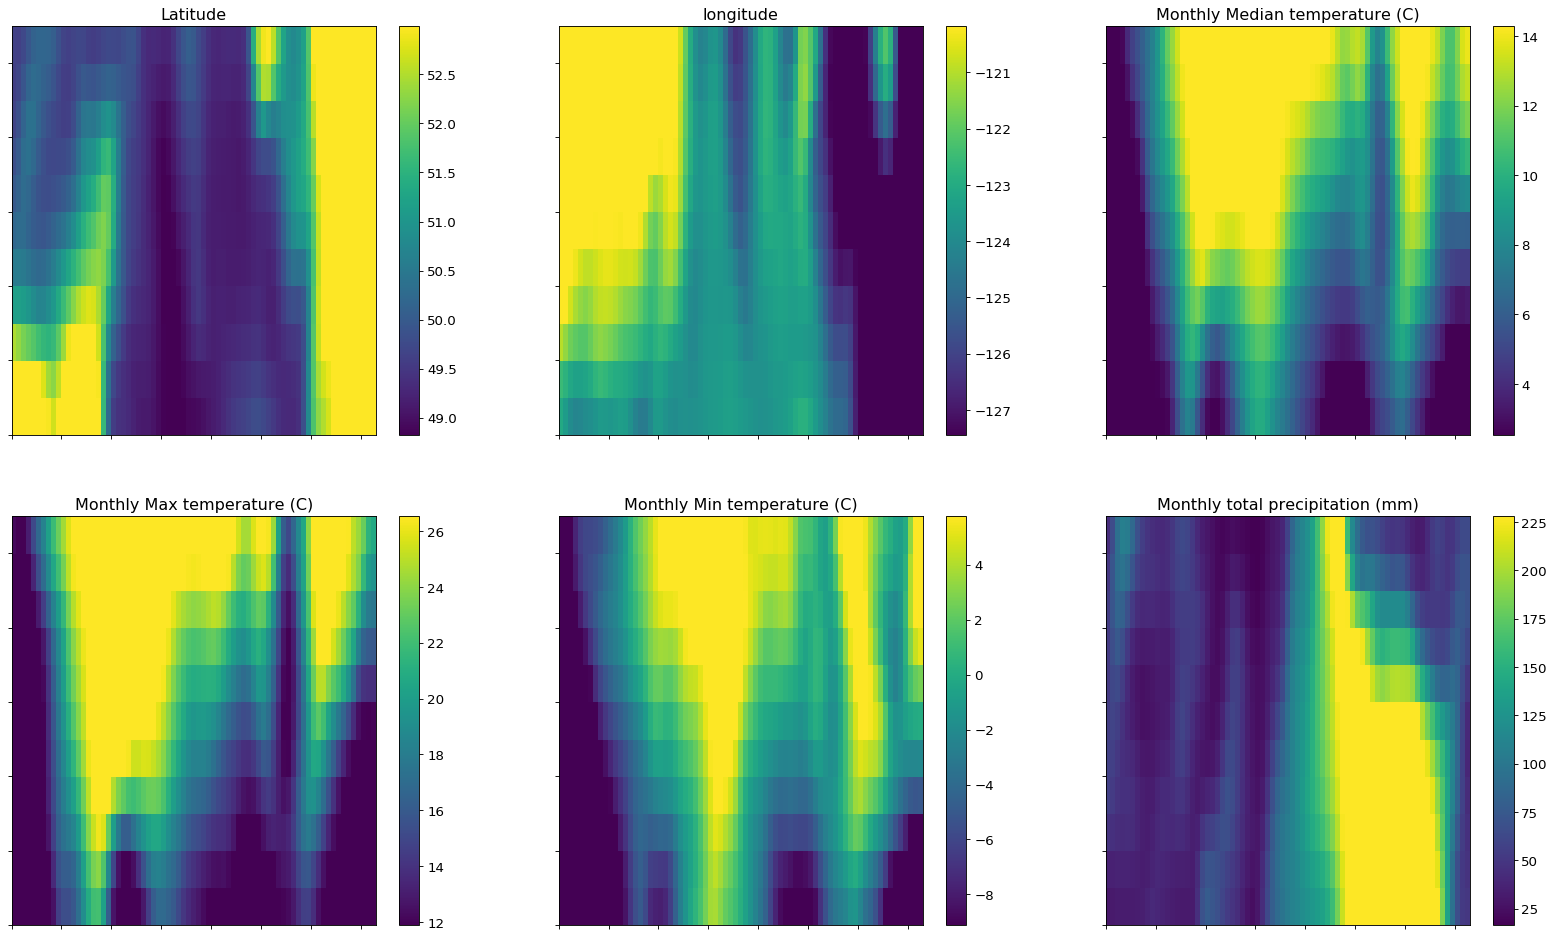

In [10]:
# Criando uma vizualizaçào para cada feature
from sompy.visualization.mapview import View2D
view2D  = View2D(width=10,height=10,title="rand data",text_size=12)
import matplotlib as mpl
view2D.show(sm, col_sz=3, which_dim="all", desnormalize=True)

import matplotlib.pylab as plt
fig = plt.gcf()
fig.set_size_inches(25,23)

Cada "pixel" dos gráficos acima simboliza um neuronio do SOM e posições iguais em gráficos diferentes significam o mesmo neurônio. Por exemplo, podemos observar que o neuronio do canto superior direito de latitude guarda uma informação de latitude perto de 49 graus norte e informação de longitude perto de 122 graus leste. 

Com isso, podemos inferir algumas informações tais como:

* A temperatura média mensal está correlacionada com a temperatura máxima mensal. 
* A precipitação parece anticorrelacionada com a precipitação.
* A área com lat. 49° N e long. 120°–124° W é a área onde há maior precipitação.

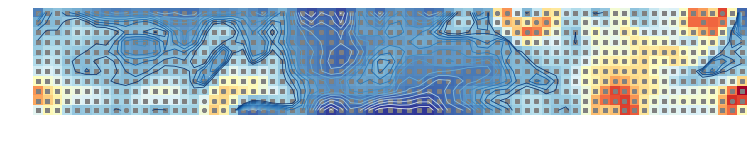

In [11]:
from sompy.visualization.umatrix import UMatrixView

umat  = UMatrixView(width=10,height=10,title='U-matrix')
umat.show(sm)

import matplotlib.pylab as plt

A visualização acima é chamada de U-matrix e representa o mapa topográfico dos neurônios do SOM. Regiões de vale representam baixas distâncias entre os vizinhos, enquanto cumes representam altas distancias entre os vizinhos. A U-matrix. é bastante útil para verificar o resultado de processos de clusterização em ciam do SOM, como o k-means. A tendencia é que as formas da clusterização sejam semelhantes às da U-matrix.

Utilizaremos o K-means para agrupar as informações organizadas pelo SOM e definir 'centros' que simbolizam diferentes configurações climáticas. Para achar o valor K ótimo, iremos ir testando todos os valores e utilizar o SSE (Sum of Squared Errors) para determinar qual o melhor K. Devido a erros na biblioteca SOMPY, precisamos redefinir o metodo cluster para que consigamos utiliza-lo apropriadamente. 

In [2]:
def cluster(self, n_clusters=8, opt = 0):
        import sklearn.cluster as clust

        print("Performing K-means SSE elbow sweep...")

        # generate the bootstrap samples
        BTS = 20
        BTS_SIZE = 0.8

        normalized_data = self._normalizer.denormalize_by(self.data_raw,
                                                          self.codebook.matrix)

        if(opt == 0):
            bts_len = int(BTS_SIZE * len(normalized_data))
            bootstrap_samples = []
            for i in range(BTS):

                temp = []
                for j in range(bts_len):
                    index = np.random.randint(0,len(normalized_data))
                    temp.append(normalized_data[index])
                temp = np.array(temp)
                bootstrap_samples.append(temp)

            SSE_BTS_K = []
            for i in range(2,n_clusters+1):

                SSE_K = []
                for l in range(BTS):
                    print("Working on bootstrap sample " + str(l) + " K: " + str(i))
                    km = clust.KMeans(n_clusters=i).fit(bootstrap_samples[l])
                    SSE = 0
                    # calculate the Sum of Square Errors and compute the elbow point
                    for k in bootstrap_samples[l]:
                        label = km.predict([k])[0]
                        SSE = SSE + np.linalg.norm(k - km.cluster_centers_[label])
                    SSE_K.append(SSE)
                # average the bootstrapped SSE's
                SSE_BTS_K.append(np.sum(SSE_K) / float(BTS))



            # find the index of the maximum value of the 1st difference and add 1 to get the optimal K
            first_diff = np.diff(SSE_BTS_K)
            print("SSE for k = 2 to " + str(n_clusters) + " " + str(SSE_BTS_K))
            index = np.argmax(first_diff) + 1

            print("Optimal K = " + str(index))

        else:
            index = opt


        km = clust.KMeans(n_clusters=index).fit(normalized_data)

        # print cluster centroids
        for i in range(index):
            print("Centroid " + str(i) + str(km.cluster_centers_[i]))

        self.cluster_labels = km.labels_
        return km.labels_, km, normalized_data

Performing K-means SSE elbow sweep...
Centroid 0[  52.28605905 -121.7421421    -3.86661663    8.12042221  -19.92035316
   46.22947923]
Centroid 1[  50.37494434 -125.34767766    6.85631562   15.62675083   -1.42431134
  270.60079155]
Centroid 2[  50.72982522 -126.73419985    6.88866959   14.84315741   -1.12018377
  586.45036101]
Centroid 3[  50.54544939 -125.08610108    7.20273266   16.65624834   -1.79265504
  139.1289073 ]
Centroid 4[  50.40972007 -126.30855549    6.72398976   14.4565335    -1.17220343
  408.83218253]
Centroid 5[  51.42778711 -122.12065897   12.65448793   26.17377996    1.34142185
   50.38424134]
Centroid 6[  50.54460203 -125.44330078    7.81488424   16.80252827   -0.45551542
  236.79401269]
Centroid 7[  51.36949996 -125.39702266    7.92930451   17.31955812   -0.6923063
   67.00165146]
Centroid 8[  51.15441125 -124.88965618    7.91069696   16.78593739   -0.45749604
   89.94318113]
Centroid 9[  50.45232548 -125.85365005    6.49748409   14.66382544   -1.61259477
  312.847

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


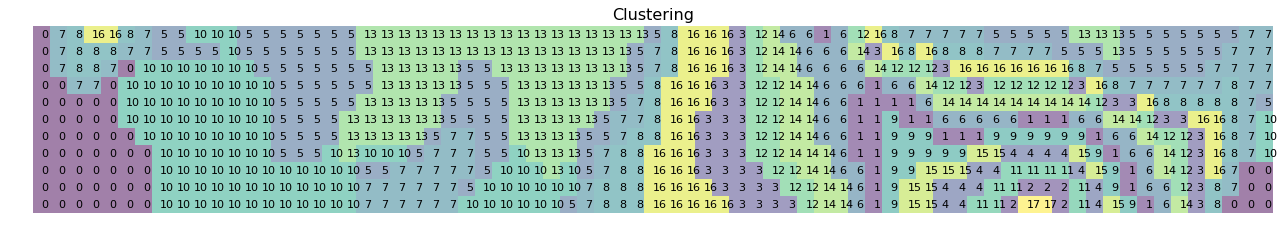

In [13]:
from sompy.visualization.hitmap import HitMapView
K = 20 # stop at this k for SSE sweep
K_opt = 18 # optimal K already found
[labels, km, norm_data] = cluster(sm, K, K_opt)
hits  = HitMapView(20,20,"Clustering",text_size=12)
a=hits.show(sm)

Como podemos observar, o mapa de clusterização apresentou resultados bastante parecidos com os da U-matrix, o que indica que o k-means executou com perfeição. Podemos também analizar os dados de cada centroide, onde as informações estão na ordem Lat, Long, Temp. Média, Temp. Máxima, Temp. Mínima e Precipitação total. 

Vamos agora apontar os centros em um mapa do Google Maps.

In [ ]:
import gmplot

gmap = gmplot.GoogleMapPlotter(54.2, -124.875224, 6)
j = 0
for i in km.cluster_centers_:
    gmap.marker(i[0],i[1],'red', title="Centroid " + str(j))
    j += 1

gmap.draw("centroids_map.html")

Como não há como abrir um html, salvamos a imagem gerada no html e salvamos para que pudessemos mostrar o mapa nesse notebook.

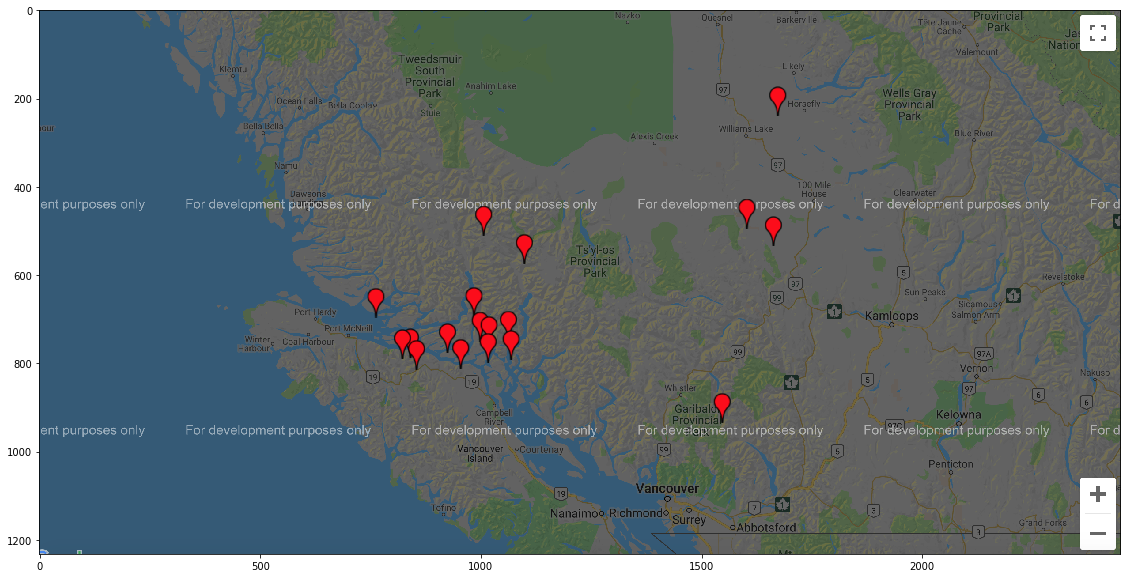

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('centroids_map.png')
plt.figure(figsize=(500,10))
imgplot = plt.imshow(img)
plt.show()

Podemos observar que os resultados condizem com os esperados do tutorial. Logo, podemos concluir que o experimento foi um sucesso.